# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 防止 tensorflow 占用所有显存

In [2]:
import tensorflow as tf
import keras.backend as K

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

# 定义数据生成器

In [3]:
from keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

# 测试生成器

Text(0.5, 1.0, 'UE8K')

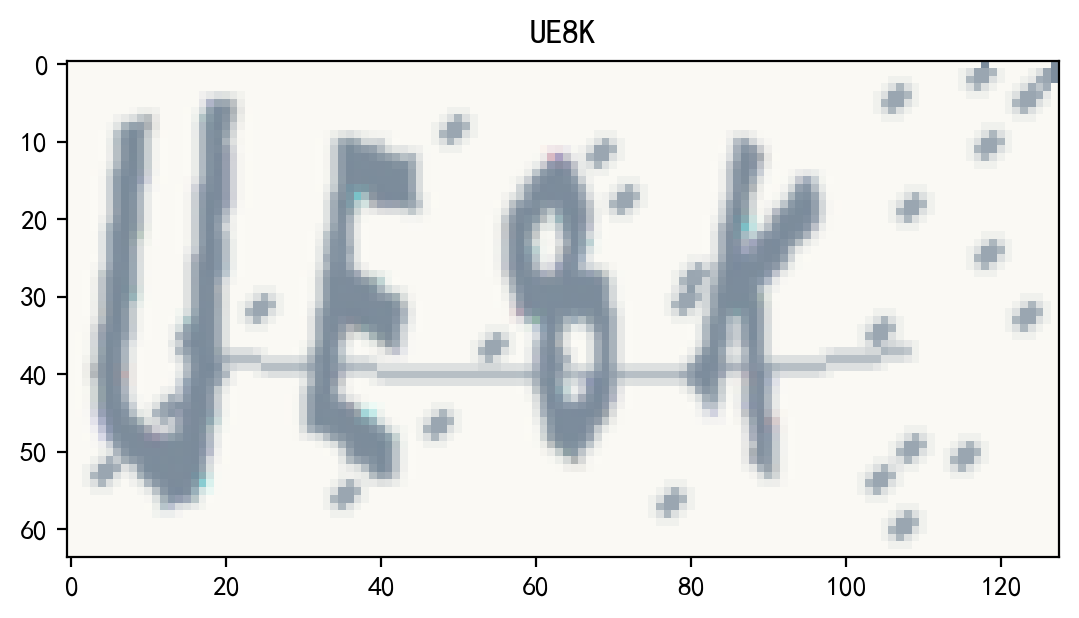

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)

X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [13]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

[(None, 36), (None, 36), (None, 36), (None, 36)]

# 网络结构可视化

可视化需要安装下面的包：

```sh
pip install pydot
sudo apt install graphviz
```

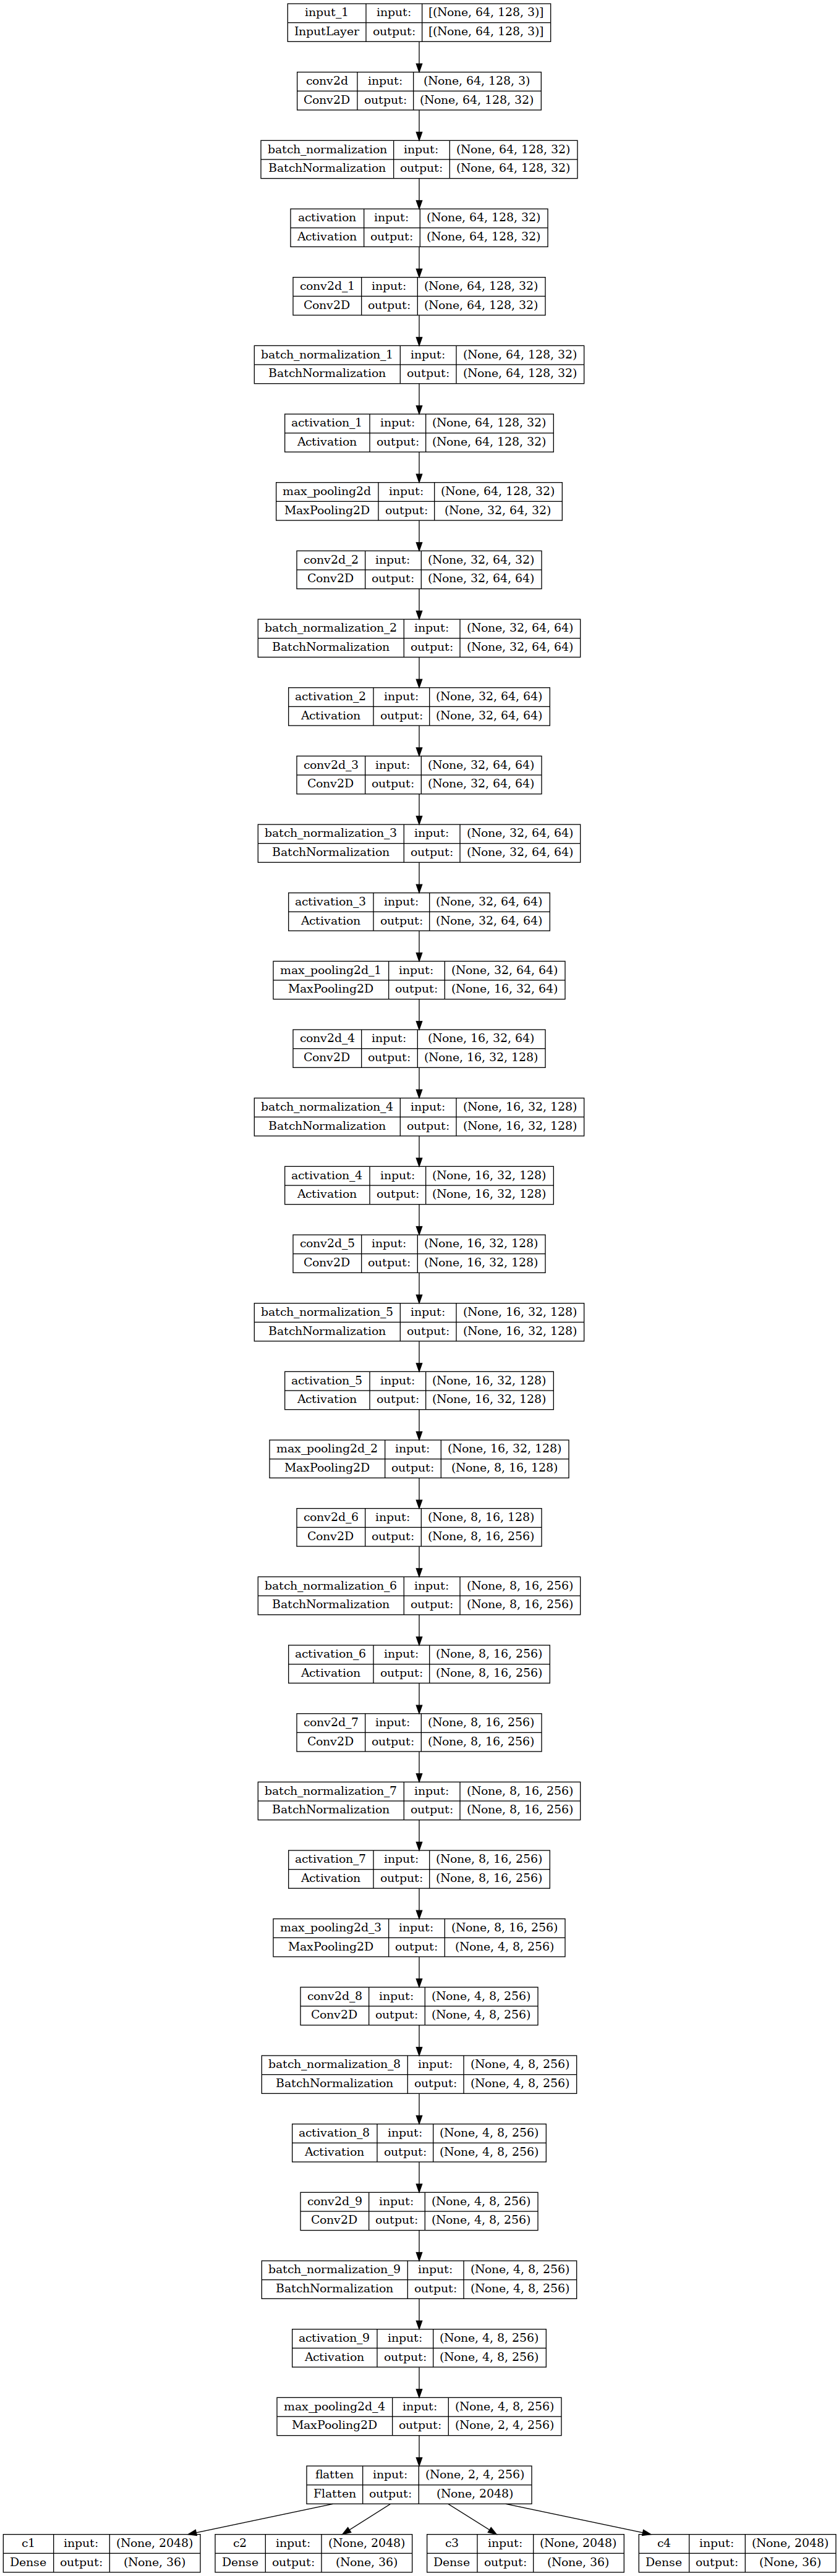

In [6]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# 训练模型

Text(0.5, 1.0, 'SM2F')

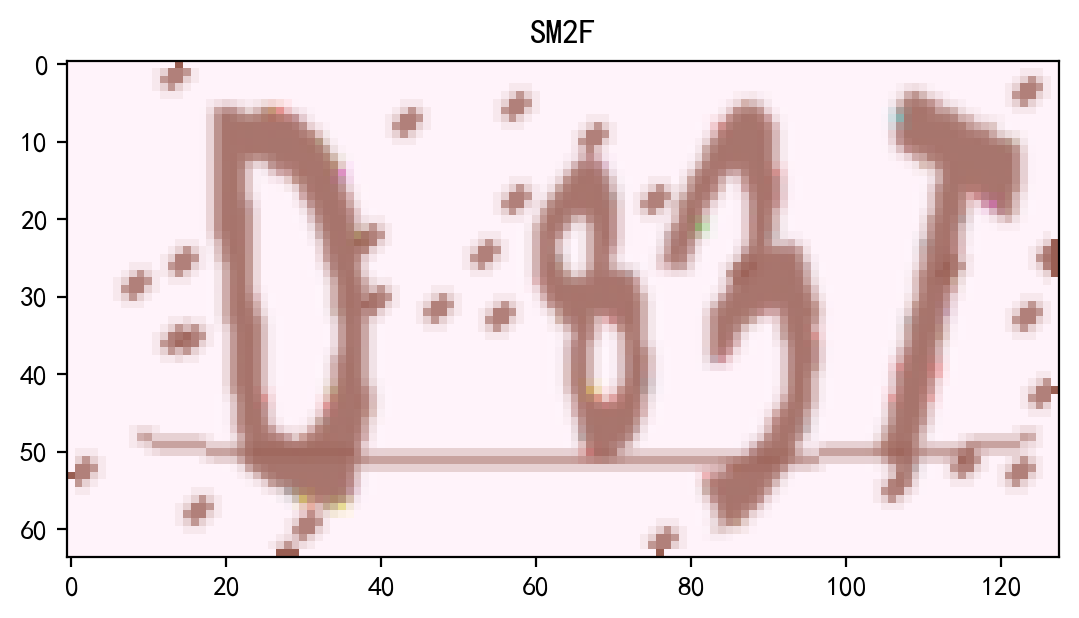

In [12]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=60, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=60, steps=100)

# callbacks = [EarlyStopping(patience=5), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(1e-3, amsgrad=True), 
#               metrics=['accuracy'])
# model.fit(train_data, epochs=100, validation_data=valid_data, workers=0, use_multiprocessing=True,
                    # callbacks=callbacks)

### 载入最好的模型继续训练一会

In [ ]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=5), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=10, validation_data=valid_data, workers=0, use_multiprocessing=True,
                    callbacks=callbacks)

In [ ]:
model.load_weights('cnn_best.h5')

# 测试模型

(-0.5, 127.5, 63.5, -0.5)

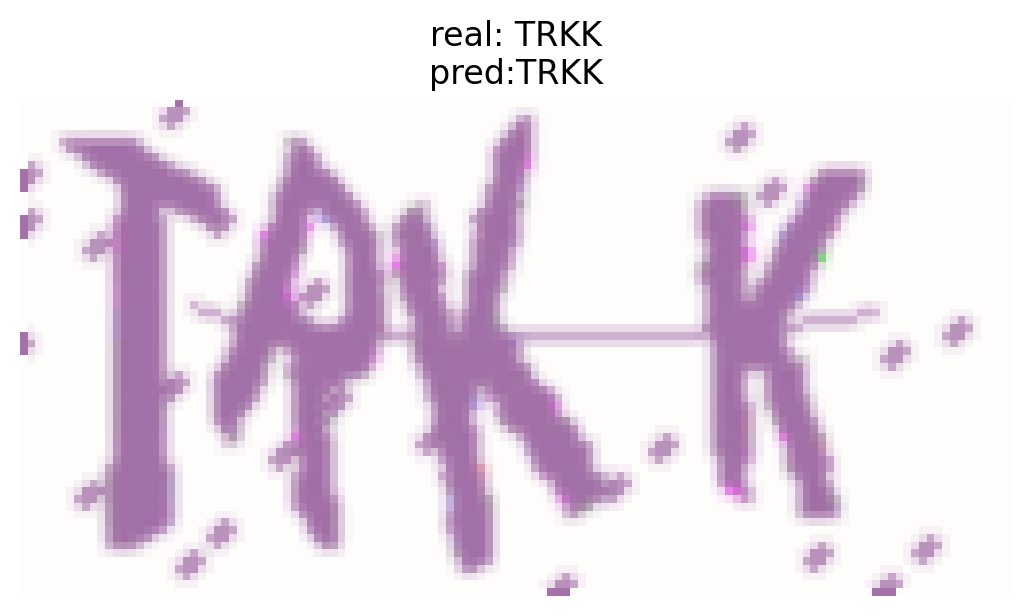

In [ ]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


0.9846875

# 保存模型

In [ ]:
model.save('cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

<AxesSubplot:>

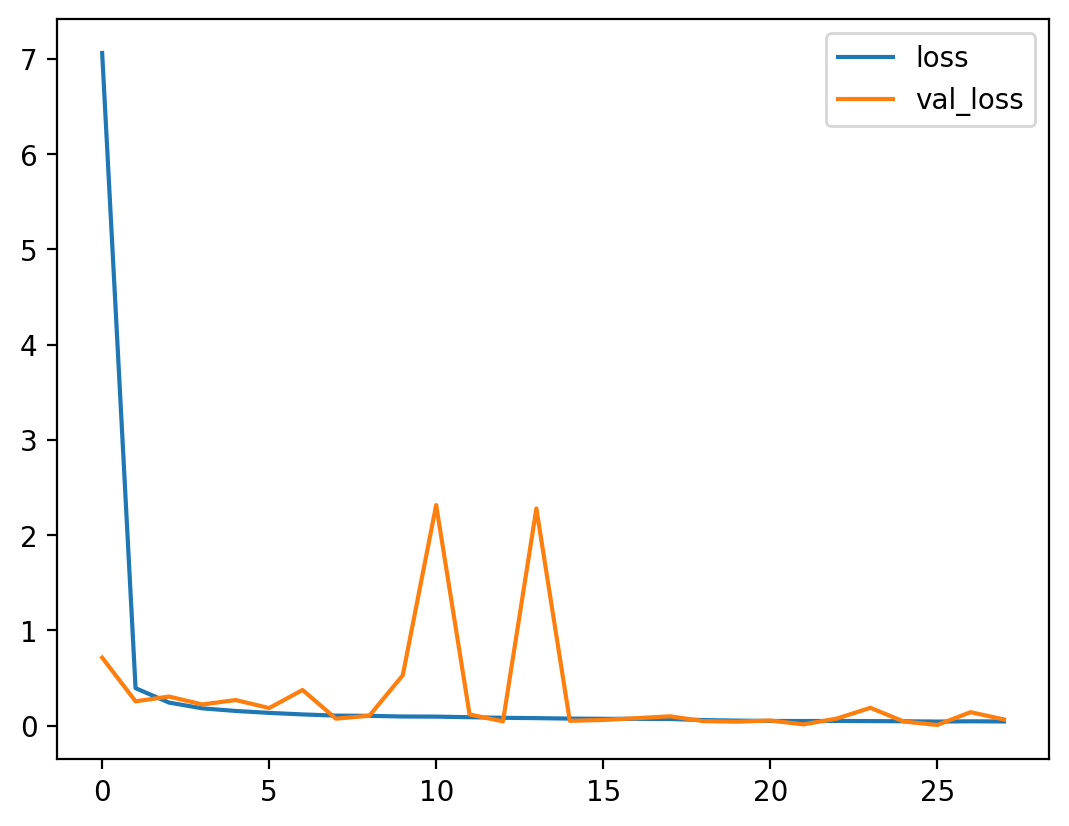

In [ ]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

<AxesSubplot:>

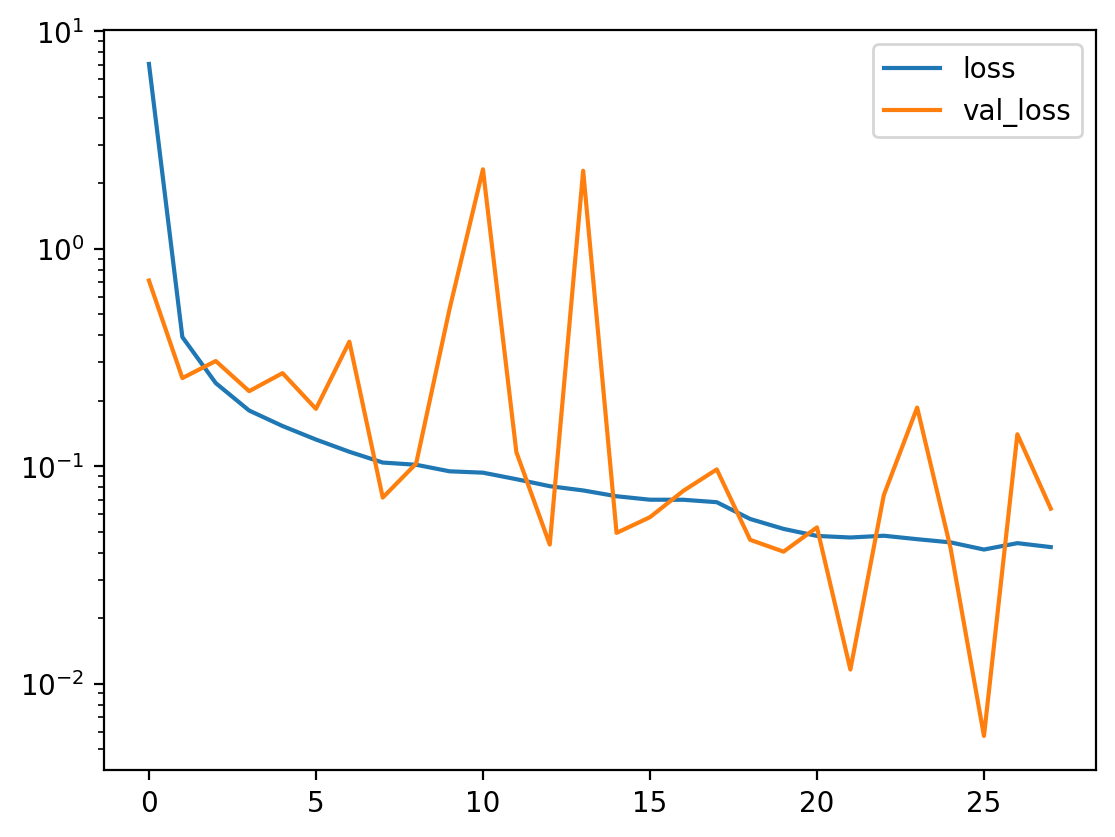

In [ ]:
df[['loss', 'val_loss']].plot(logy=True)